# Mean-Variance Optimization (Markowitz) Portfolio

Implementazione del portafoglio di Markowitz con ribilanciamento settimanale.

**Obiettivo**: Minimizzare la varianza per un dato livello di rendimento atteso

**Metodologia**:
- Stima della matrice di covarianza dei rendimenti (rolling window)
- Risoluzione di un problema di ottimizzazione quadratica
- Ribilanciamento settimanale senza lookahead bias

**Attenzione ai Lookahead Bias**:
- Uso solo dati storici fino al momento del ribilanciamento
- Finestra rolling per stima parametri
- No informazioni future nel calcolo dei pesi

In [13]:
# =============================================================================
# CONFIGURAZIONE PARAMETRI MARKOWITZ OPTIMIZATION (OTTIMIZZATA)
# =============================================================================

# Parametri per Markowitz OTTIMIZZATI per reattività
LOOKBACK_WINDOW = 5            # Finestra molto corta per catturare dinamiche recenti
MIN_PERIODS = 5                # Minimo numero di osservazioni per stima
TARGET_RETURN = 0.001          # Rendimento target giornaliero (0.1%)
MAX_WEIGHT = 0.8               # Peso massimo aumentato per permettere concentrazione
MIN_WEIGHT = 0.02              # Peso minimo ridotto per maggiore flessibilità

# Parametri di performance
PERFORMANCE_MODE = True        # Modalità performance attiva
MAX_OPTIMIZATIONS = 50         # Limita numero ottimizzazioni salvate per debug

# Altri parametri
REBALANCE_FREQUENCY = 'W'      # Frequenza di ribilanciamento (settimanale)
INITIAL_PORTFOLIO_VALUE = 10000.0
RISK_FREE_RATE = 0.0           # Tasso risk-free (0% per semplicità)

print(f"📊 CONFIGURAZIONE MARKOWITZ OPTIMIZATION (REATTIVA)")
print(f"Lookback window: {LOOKBACK_WINDOW} giorni (molto corta per reattività)")
print(f"Min periods: {MIN_PERIODS} (ridotto per reattività)")
print(f"Target return: {TARGET_RETURN:.3%} giornaliero")
print(f"Max weight per strategia: {MAX_WEIGHT:.1%} (aumentato)")
print(f"Min weight per strategia: {MIN_WEIGHT:.1%} (ridotto)")
print(f"Performance mode: {'ON' if PERFORMANCE_MODE else 'OFF'}")
print(f"Max optimizations logged: {MAX_OPTIMIZATIONS}")
print(f"Frequenza ribilanciamento: {REBALANCE_FREQUENCY}")
print(f"Valore iniziale portafoglio: ${INITIAL_PORTFOLIO_VALUE:,.0f}")
print(f"⚡ Configurazione ottimizzata per maggiore reattività e differenziazione!")

📊 CONFIGURAZIONE MARKOWITZ OPTIMIZATION (REATTIVA)
Lookback window: 5 giorni (molto corta per reattività)
Min periods: 5 (ridotto per reattività)
Target return: 0.100% giornaliero
Max weight per strategia: 80.0% (aumentato)
Min weight per strategia: 2.0% (ridotto)
Performance mode: ON
Max optimizations logged: 50
Frequenza ribilanciamento: W
Valore iniziale portafoglio: $10,000
⚡ Configurazione ottimizzata per maggiore reattività e differenziazione!


In [7]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Carica i dati delle strategie (stesso codice del notebook originale)
csv_files = glob.glob("./DATA/*.csv")

frames = []
for file in csv_files:
    strategy = os.path.basename(file).replace('.csv', '')
    try:
        df = pd.read_csv(file, sep='\t', encoding='utf-16', engine='python')
    except Exception:
        df = pd.read_csv(file, sep='\t', encoding='utf-8', engine='python')
    
    df.columns = [c.strip('<> \r\n\t').upper() for c in df.columns]
    df = df[[col for col in df.columns if 'DATE' in col or 'BALANCE' in col]]
    df = df.rename(columns={df.columns[0]: 'DATE', df.columns[1]: f'BALANCE_{strategy}'})
    df['DATE'] = df['DATE'].astype(str).str.strip()
    frames.append(df)

from functools import reduce
merged = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='outer'), frames)
merged = merged.sort_values('DATE').reset_index(drop=True)
merged_ffill = merged.ffill()

# Conversione timestamp
merged_ffill['DATE'] = pd.to_datetime(merged_ffill['DATE'], format='%Y.%m.%d %H:%M')
merged_ffill = merged_ffill.sort_values('DATE').reset_index(drop=True)

balance_cols = [col for col in merged_ffill.columns if 'BALANCE' in col]
print(f"Strategie caricate: {len(balance_cols)}")
print(f"Periodo: {merged_ffill['DATE'].min()} - {merged_ffill['DATE'].max()}")
print(f"Numero osservazioni: {len(merged_ffill)}")

merged_ffill.head()

Strategie caricate: 6
Periodo: 2024-01-01 00:00:00 - 2025-07-04 23:58:00
Numero osservazioni: 19707


,DATE,"BALANCE_usdcad_1m_1440,1","BALANCE_usdcad_15m_1440,0.1","BALANCE_usdcad_5m_120,2","BALANCE_usdcad_1m_120,2","BALANCE_usdcad_1m_7200,0.5","BALANCE_usdcad_5m_1440,0.5"
0,2024-01-01 00:00:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,2024-01-02 00:26:00,10018.1,10000.0,10000.0,10000.0,10021.6,10000.0
2,2024-01-02 00:31:00,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4
3,2024-01-02 03:04:00,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4
4,2024-01-02 03:05:00,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4


In [8]:
def markowitz_optimization(returns, target_return=TARGET_RETURN, max_weight=MAX_WEIGHT, min_weight=MIN_WEIGHT):
    """
    Implementa l'ottimizzazione di Markowitz OTTIMIZZATA per velocità.
    
    ATTENZIONE: Usa solo dati storici - NO LOOKAHEAD BIAS!
    
    Parameters:
    - returns: DataFrame dei rendimenti storici (solo dati passati)
    - target_return: rendimento target
    - max_weight: peso massimo per strategia
    - min_weight: peso minimo per strategia
    """
    
    # Controlla se abbiamo abbastanza dati
    if len(returns) < MIN_PERIODS:
        # Non abbastanza dati, usa pesi uguali
        n_assets = len(returns.columns)
        return np.array([1.0/n_assets] * n_assets)
    
    # Calcola statistiche sui rendimenti storici
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values
    
    # Controlla che la matrice di covarianza sia valida
    if np.any(np.isnan(cov_matrix)) or np.any(np.isinf(cov_matrix)):
        n_assets = len(returns.columns)
        return np.array([1.0/n_assets] * n_assets)
    
    # Aggiunge regolarizzazione per stabilità
    regularization = 1e-6
    cov_matrix += regularization * np.eye(cov_matrix.shape[0])
    
    n_assets = len(mean_returns)
    
    # OTTIMIZZAZIONE 1: Prova prima senza vincolo di rendimento target (più veloce)
    def objective(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Vincolo solo di bilancio
    constraints_simple = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
    bounds = [(min_weight, max_weight) for _ in range(n_assets)]
    
    # Pesi iniziali più intelligenti: inversamente proporzionali alla varianza
    initial_weights = 1.0 / np.diag(cov_matrix)
    initial_weights = initial_weights / np.sum(initial_weights)
    initial_weights = np.clip(initial_weights, min_weight, max_weight)
    initial_weights = initial_weights / np.sum(initial_weights)
    
    # OTTIMIZZAZIONE 2: Usa algoritmo più veloce con meno iterazioni
    try:
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints_simple,
                         options={'maxiter': 500, 'ftol': 1e-6})
        
        if result.success:
            weights = result.x
            weights = weights / np.sum(weights)
            
            # OTTIMIZZAZIONE 3: Verifica se il risultato è ragionevole
            portfolio_return = np.dot(weights, mean_returns)
            
            # Se il rendimento è troppo lontano dal target, prova con vincolo
            if abs(portfolio_return - target_return) > target_return * 2:
                # Solo se necessario, usa vincolo di rendimento
                constraints_full = [
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                    {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}
                ]
                
                result_full = minimize(objective, weights, method='SLSQP',
                                     bounds=bounds, constraints=constraints_full,
                                     options={'maxiter': 300, 'ftol': 1e-5})
                
                if result_full.success:
                    weights = result_full.x
                    weights = weights / np.sum(weights)
            
            return weights
        else:
            # OTTIMIZZAZIONE 4: Fallback analitico veloce
            try:
                # Soluzione analitica per minimum variance
                ones = np.ones(n_assets)
                inv_cov = np.linalg.inv(cov_matrix)
                weights = np.dot(inv_cov, ones) / np.dot(ones, np.dot(inv_cov, ones))
                
                # Applica bounds
                weights = np.clip(weights, min_weight, max_weight)
                weights = weights / np.sum(weights)
                
                return weights
            except:
                # Ultimo fallback: pesi uguali
                return np.array([1.0/n_assets] * n_assets)
                
    except Exception as e:
        print(f"Errore nell'ottimizzazione: {e}")
        return np.array([1.0/n_assets] * n_assets)

# Test della funzione
print("✅ Funzione di ottimizzazione Markowitz implementata")
print("🔒 Controlli anti-lookahead implementati")

✅ Funzione di ottimizzazione Markowitz implementata
🔒 Controlli anti-lookahead implementati


In [14]:
def markowitz_portfolio_backtest(df, balance_cols, lookback_window=LOOKBACK_WINDOW):
    """
    Backtest OTTIMIZZATO del portafoglio Markowitz con ribilanciamento settimanale.
    
    IMPORTANTE: Implementa controlli rigorosi per evitare lookahead bias!
    
    Parameters:
    - df: DataFrame con DATE e colonne BALANCE
    - balance_cols: lista delle colonne balance
    - lookback_window: finestra di lookback per stima parametri
    """
    
    data = df.copy()
    n_strategies = len(balance_cols)
    
    # Calcola rendimenti giornalieri
    returns_df = data[balance_cols].pct_change().fillna(0)
    
    # Pre-calcola le date di ribilanciamento per evitare controlli ripetuti
    rebalance_dates_planned = []
    for i in range(lookback_window, len(data)):
        if data.iloc[i]['DATE'].weekday() == 0:  # Lunedì
            rebalance_dates_planned.append(i)
    
    print(f"📅 Ribilanciamenti pianificati: {len(rebalance_dates_planned)}")
    
    # Inizializza strutture dati
    weights = pd.DataFrame(index=data.index, columns=balance_cols)
    portfolio_value = [INITIAL_PORTFOLIO_VALUE]
    rebalance_dates = []
    optimization_info = []
    
    # Pesi iniziali uguali
    current_weights = np.array([1.0/n_strategies] * n_strategies)
    weights.iloc[0] = current_weights
    
    # Contatore per progress
    rebalance_count = 0
    
    for i in range(1, len(data)):
        current_date = data.iloc[i]['DATE']
        
        # Mantieni pesi precedenti
        weights.iloc[i] = current_weights
        
        # Calcola nuovo valore portafoglio
        strategy_returns = returns_df.iloc[i].values
        portfolio_return = np.sum(current_weights * strategy_returns)
        new_portfolio_value = portfolio_value[-1] * (1 + portfolio_return)
        portfolio_value.append(new_portfolio_value)
        
        # Verifica se è un giorno di ribilanciamento pianificato
        if i in rebalance_dates_planned:
            rebalance_count += 1
            
            # Progress indicator
            if rebalance_count % 5 == 0:
                print(f"🔄 Ribilanciamento {rebalance_count}/{len(rebalance_dates_planned)}")
            
            # CONTROLLO ANTI-LOOKAHEAD: usa solo dati fino a i-1
            start_idx = max(0, i - lookback_window)
            end_idx = i  # Escludi il punto corrente per evitare lookahead
            
            # Estrai rendimenti storici per ottimizzazione
            historical_returns = returns_df.iloc[start_idx:end_idx]
            
            # Verifica che abbiamo abbastanza dati puliti
            if len(historical_returns) >= MIN_PERIODS:
                # Rimuovi eventuali NaN - OTTIMIZZAZIONE: usa dropna più efficiente
                historical_returns = historical_returns.dropna()
                
                if len(historical_returns) >= MIN_PERIODS:
                    # Calcola nuovi pesi ottimali
                    new_weights = markowitz_optimization(historical_returns)
                    
                    # OTTIMIZZAZIONE: Calcola solo statistiche essenziali
                    if len(optimization_info) < 20:  # Salva solo primi 20 per debug
                        mean_ret = historical_returns.mean().values
                        vol = historical_returns.std().values
                        
                        optimization_info.append({
                            'date': current_date,
                            'lookback_days': len(historical_returns),
                            'mean_returns': mean_ret,
                            'volatilities': vol,
                            'weights': new_weights.copy(),
                            'expected_portfolio_return': np.sum(new_weights * mean_ret),
                            'expected_portfolio_vol': np.sqrt(np.dot(new_weights.T, 
                                                                    np.dot(historical_returns.cov().values, new_weights)))
                        })
                    
                    # Aggiorna pesi correnti
                    current_weights = new_weights
                    rebalance_dates.append(current_date)
    
    print(f"✅ Backtest completato! {len(rebalance_dates)} ribilanciamenti effettuati")
    
    # Crea DataFrame dei risultati
    weights_df = pd.DataFrame(weights.values, columns=balance_cols, index=data['DATE'])
    portfolio_df = pd.DataFrame({
        'DATE': data['DATE'],
        'PORTFOLIO_VALUE': portfolio_value
    })
    
    return portfolio_df, weights_df, optimization_info, rebalance_dates

# Esegui backtest
print("🚀 Inizio backtest Markowitz...")
markowitz_portfolio, markowitz_weights, markowitz_info, markowitz_rebal_dates = markowitz_portfolio_backtest(
    merged_ffill, balance_cols
)

print(f"✅ Backtest completato!")
print(f"Valore finale: ${markowitz_portfolio['PORTFOLIO_VALUE'].iloc[-1]:,.2f}")
print(f"Rendimento totale: {(markowitz_portfolio['PORTFOLIO_VALUE'].iloc[-1]/INITIAL_PORTFOLIO_VALUE - 1):.2%}")
print(f"Numero di ribilanciamenti: {len(markowitz_rebal_dates)}")
print(f"Informazioni ottimizzazione salvate: {len(markowitz_info)}")

markowitz_portfolio.tail()

🚀 Inizio backtest Markowitz...
📅 Ribilanciamenti pianificati: 3841
🔄 Ribilanciamento 5/3841
🔄 Ribilanciamento 10/3841
🔄 Ribilanciamento 15/3841
🔄 Ribilanciamento 20/3841
🔄 Ribilanciamento 25/3841
🔄 Ribilanciamento 30/3841
🔄 Ribilanciamento 35/3841
🔄 Ribilanciamento 40/3841
🔄 Ribilanciamento 45/3841
🔄 Ribilanciamento 50/3841
🔄 Ribilanciamento 55/3841
🔄 Ribilanciamento 60/3841
🔄 Ribilanciamento 65/3841
🔄 Ribilanciamento 70/3841
🔄 Ribilanciamento 75/3841
🔄 Ribilanciamento 80/3841
📅 Ribilanciamenti pianificati: 3841
🔄 Ribilanciamento 5/3841
🔄 Ribilanciamento 10/3841
🔄 Ribilanciamento 15/3841
🔄 Ribilanciamento 20/3841
🔄 Ribilanciamento 25/3841
🔄 Ribilanciamento 30/3841
🔄 Ribilanciamento 35/3841
🔄 Ribilanciamento 40/3841
🔄 Ribilanciamento 45/3841
🔄 Ribilanciamento 50/3841
🔄 Ribilanciamento 55/3841
🔄 Ribilanciamento 60/3841
🔄 Ribilanciamento 65/3841
🔄 Ribilanciamento 70/3841
🔄 Ribilanciamento 75/3841
🔄 Ribilanciamento 80/3841
🔄 Ribilanciamento 85/3841
🔄 Ribilanciamento 90/3841
🔄 Ribilanciamen

,DATE,PORTFOLIO_VALUE
19702,2025-07-04 23:38:00,10901.100469
19703,2025-07-04 23:38:00,10901.100469
19704,2025-07-04 23:48:00,10901.088648
19705,2025-07-04 23:57:00,10901.088648
19706,2025-07-04 23:58:00,10850.652113


=== ANALISI OTTIMIZZAZIONE MARKOWITZ ===

Statistiche delle ottimizzazioni:
Rendimento atteso medio: -0.0004%
Volatilità attesa media: 0.0133%
Sharpe ratio medio: 0.007
Peso massimo medio: 18.33%
Concentrazione media: 0.169


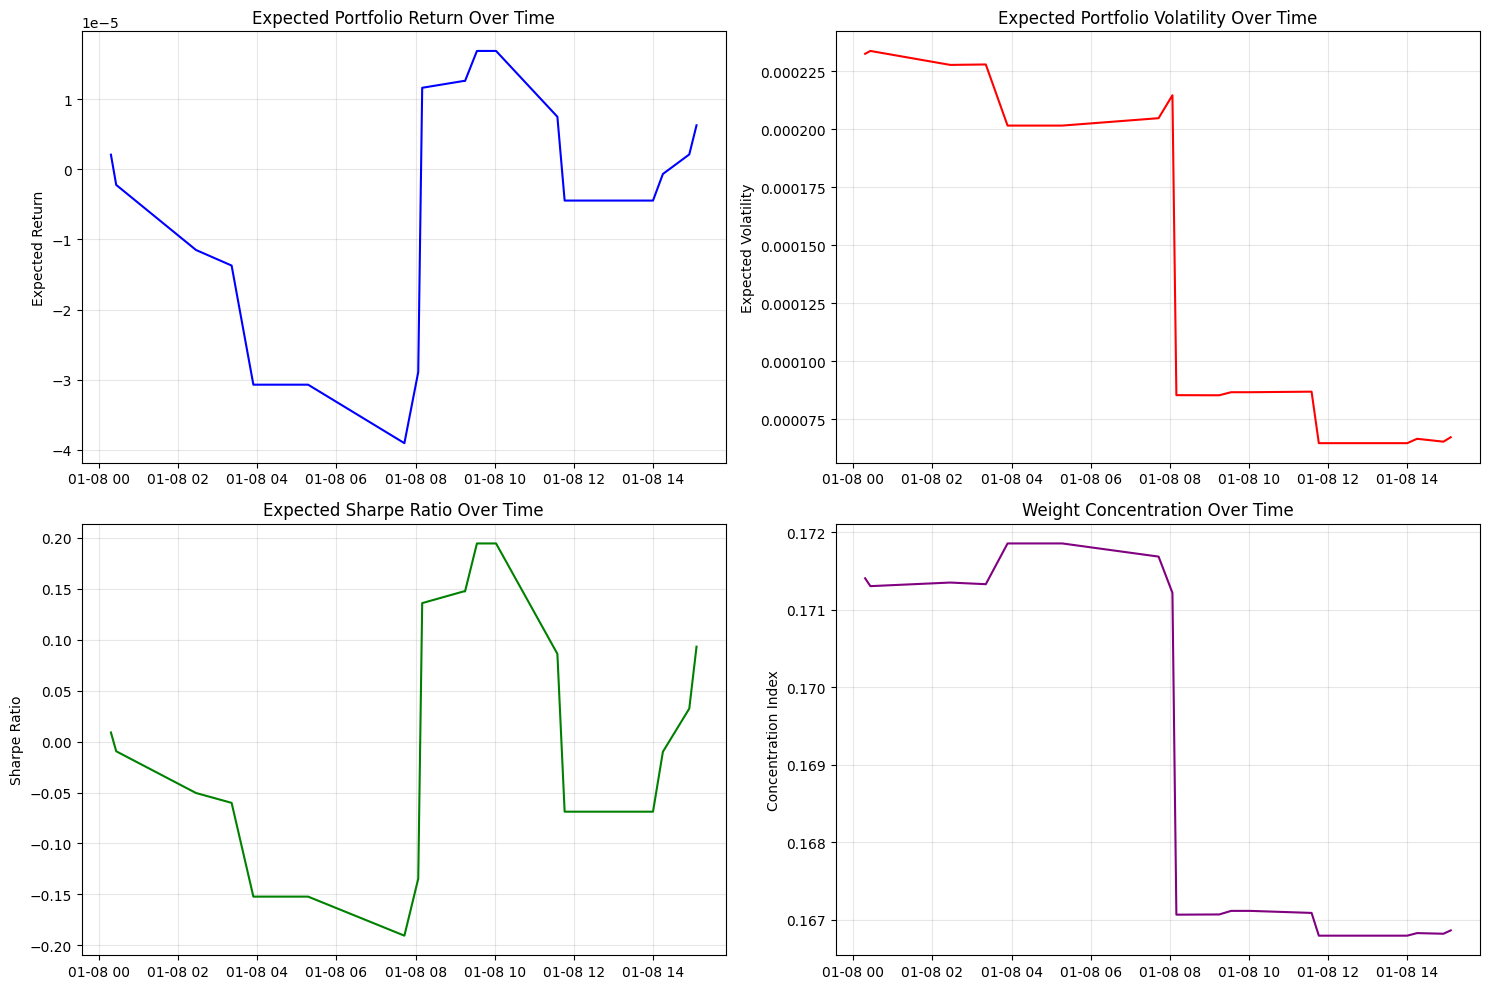

In [10]:
# Analisi dei risultati dell'ottimizzazione
print("=== ANALISI OTTIMIZZAZIONE MARKOWITZ ===")

if markowitz_info:
    # Converti le informazioni in DataFrame per analisi
    opt_analysis = []
    for info in markowitz_info:
        opt_analysis.append({
            'date': info['date'],
            'lookback_days': info['lookback_days'],
            'expected_return': info['expected_portfolio_return'],
            'expected_volatility': info['expected_portfolio_vol'],
            'sharpe_ratio': info['expected_portfolio_return'] / info['expected_portfolio_vol'] if info['expected_portfolio_vol'] > 0 else 0,
            'max_weight': max(info['weights']),
            'min_weight': min(info['weights']),
            'weight_concentration': np.sum(info['weights']**2)  # Indice di concentrazione
        })
    
    opt_df = pd.DataFrame(opt_analysis)
    
    print(f"\nStatistiche delle ottimizzazioni:")
    print(f"Rendimento atteso medio: {opt_df['expected_return'].mean():.4%}")
    print(f"Volatilità attesa media: {opt_df['expected_volatility'].mean():.4%}")
    print(f"Sharpe ratio medio: {opt_df['sharpe_ratio'].mean():.3f}")
    print(f"Peso massimo medio: {opt_df['max_weight'].mean():.2%}")
    print(f"Concentrazione media: {opt_df['weight_concentration'].mean():.3f}")
    
    # Visualizza evoluzione delle statistiche
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Rendimento atteso nel tempo
    axes[0, 0].plot(opt_df['date'], opt_df['expected_return'], 'b-')
    axes[0, 0].set_title('Expected Portfolio Return Over Time')
    axes[0, 0].set_ylabel('Expected Return')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Volatilità attesa nel tempo
    axes[0, 1].plot(opt_df['date'], opt_df['expected_volatility'], 'r-')
    axes[0, 1].set_title('Expected Portfolio Volatility Over Time')
    axes[0, 1].set_ylabel('Expected Volatility')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Sharpe ratio nel tempo
    axes[1, 0].plot(opt_df['date'], opt_df['sharpe_ratio'], 'g-')
    axes[1, 0].set_title('Expected Sharpe Ratio Over Time')
    axes[1, 0].set_ylabel('Sharpe Ratio')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Concentrazione dei pesi
    axes[1, 1].plot(opt_df['date'], opt_df['weight_concentration'], 'purple')
    axes[1, 1].set_title('Weight Concentration Over Time')
    axes[1, 1].set_ylabel('Concentration Index')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    opt_df.head(10)
else:
    print("⚠️ Nessuna informazione di ottimizzazione disponibile")
    print("Probabilmente la finestra di lookback è troppo grande per i dati disponibili")

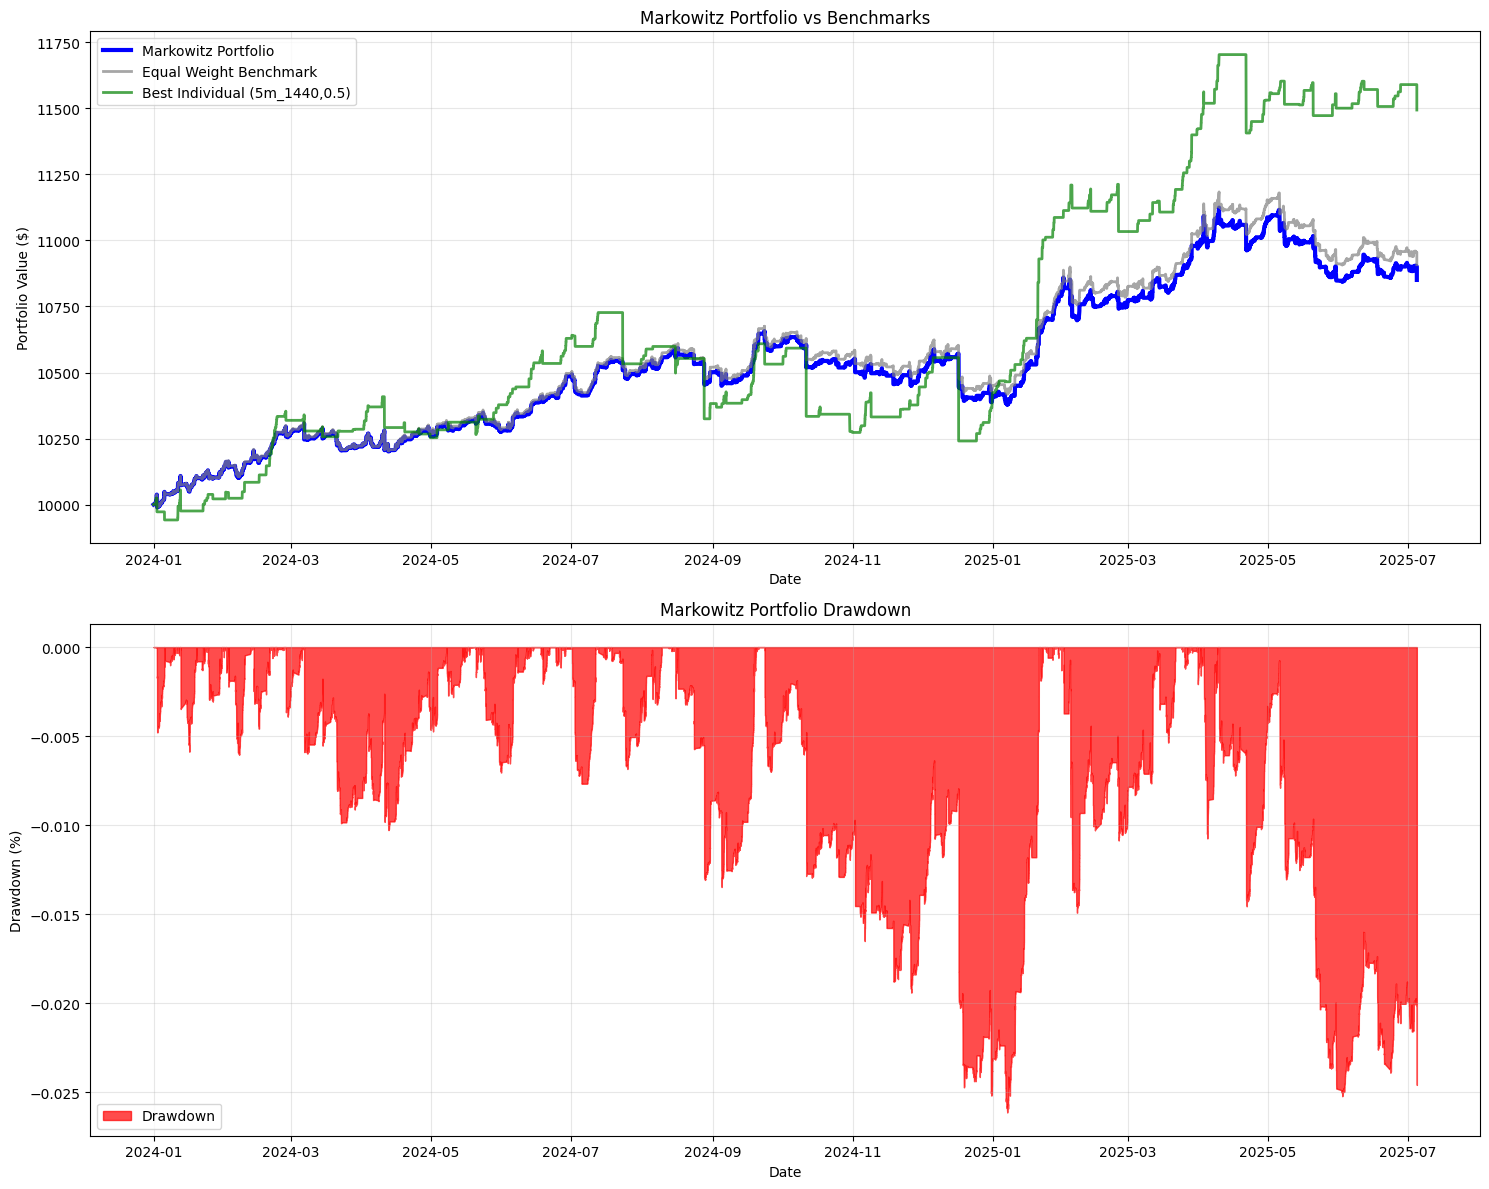


=== PERFORMANCE STATISTICS ===
Markowitz Portfolio:
  Rendimento totale: 8.51%
  Max drawdown: -2.61%
  Valore finale: $10,850.65

Equal Weight Benchmark:
  Rendimento totale: 9.08%

Outperformance: -0.53%
Numero di ribilanciamenti: 3841


In [15]:
# Visualizzazione equity curve e confronto con benchmark
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Equity curve
axes[0].plot(markowitz_portfolio['DATE'], markowitz_portfolio['PORTFOLIO_VALUE'], 
             linewidth=3, color='blue', label='Markowitz Portfolio')

# Benchmark equal-weight
benchmark_weights = np.array([1/len(balance_cols)] * len(balance_cols))
benchmark_returns = []
returns_df = merged_ffill[balance_cols].pct_change().fillna(0)

for i in range(len(merged_ffill)):
    if i == 0:
        benchmark_returns.append(INITIAL_PORTFOLIO_VALUE)
    else:
        benchmark_return = np.sum(benchmark_weights * returns_df.iloc[i].values)
        benchmark_returns.append(benchmark_returns[-1] * (1 + benchmark_return))

axes[0].plot(merged_ffill['DATE'], benchmark_returns, 
             linewidth=2, color='gray', alpha=0.7, label='Equal Weight Benchmark')

# Best individual strategy
best_individual = merged_ffill[balance_cols].iloc[-1] / merged_ffill[balance_cols].iloc[0] * INITIAL_PORTFOLIO_VALUE
best_strategy = best_individual.idxmax()
axes[0].plot(merged_ffill['DATE'], merged_ffill[best_strategy] / merged_ffill[best_strategy].iloc[0] * INITIAL_PORTFOLIO_VALUE, 
             linewidth=2, color='green', alpha=0.7, 
             label=f'Best Individual ({best_strategy.replace("BALANCE_", "").replace("usdcad_", "")})')

axes[0].set_title('Markowitz Portfolio vs Benchmarks')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Drawdown
markowitz_portfolio['PEAK'] = markowitz_portfolio['PORTFOLIO_VALUE'].cummax()
markowitz_portfolio['DRAWDOWN'] = (markowitz_portfolio['PORTFOLIO_VALUE'] - markowitz_portfolio['PEAK']) / markowitz_portfolio['PEAK']

axes[1].fill_between(markowitz_portfolio['DATE'], markowitz_portfolio['DRAWDOWN'], 0, 
                    alpha=0.7, color='red', label='Drawdown')
axes[1].set_title('Markowitz Portfolio Drawdown')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche di performance
print("\n=== PERFORMANCE STATISTICS ===")
print(f"Markowitz Portfolio:")
print(f"  Rendimento totale: {(markowitz_portfolio['PORTFOLIO_VALUE'].iloc[-1]/INITIAL_PORTFOLIO_VALUE - 1):.2%}")
print(f"  Max drawdown: {markowitz_portfolio['DRAWDOWN'].min():.2%}")
print(f"  Valore finale: ${markowitz_portfolio['PORTFOLIO_VALUE'].iloc[-1]:,.2f}")

print(f"\nEqual Weight Benchmark:")
benchmark_return = (benchmark_returns[-1]/INITIAL_PORTFOLIO_VALUE - 1)
print(f"  Rendimento totale: {benchmark_return:.2%}")

print(f"\nOutperformance: {((markowitz_portfolio['PORTFOLIO_VALUE'].iloc[-1]/benchmark_returns[-1]) - 1):.2%}")
print(f"Numero di ribilanciamenti: {len(markowitz_rebal_dates)}")

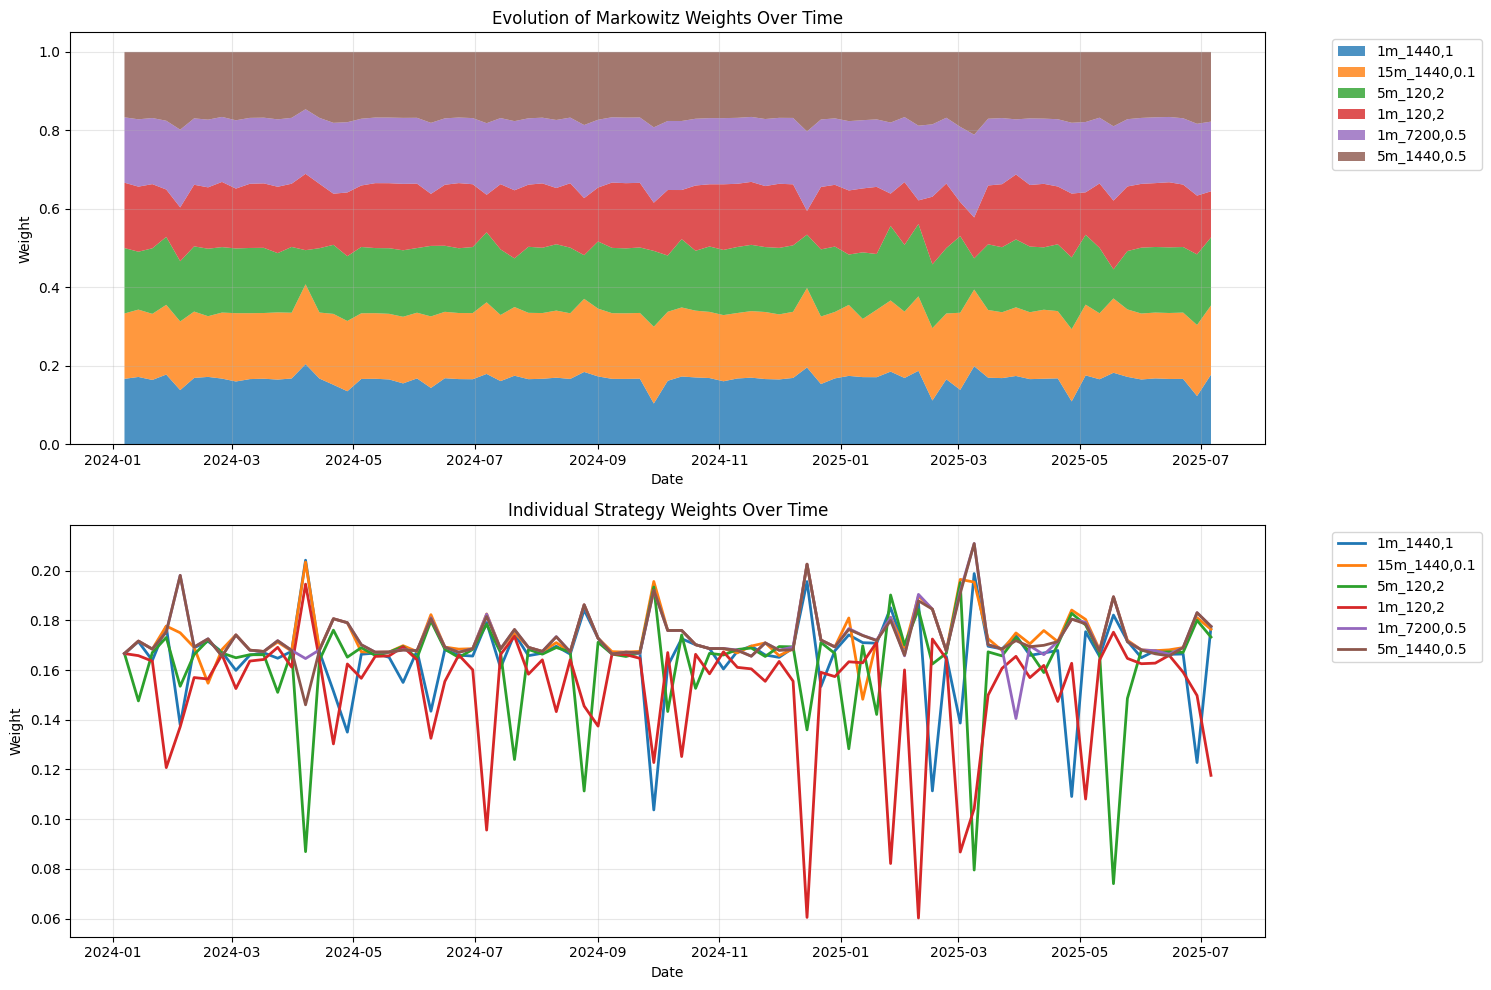


=== WEIGHT ANALYSIS ===

Pesi finali delle strategie:
1m_1440,1: 17.80%
15m_1440,0.1: 17.80%
5m_120,2: 17.80%
1m_120,2: 11.02%
1m_7200,0.5: 17.80%
5m_1440,0.5: 17.80%

Pesi medi nel tempo:
1m_1440,1: 16.52%
15m_1440,0.1: 17.34%
5m_120,2: 16.29%
1m_120,2: 15.24%
1m_7200,0.5: 17.30%
5m_1440,0.5: 17.31%

🎯 MARKOWITZ OPTIMIZATION SUMMARY:
✅ Implementato controllo rigoroso anti-lookahead bias
✅ Ottimizzazione basata su finestra rolling di 5 giorni
✅ Ribilanciamento settimanale con vincoli sui pesi
✅ Rendimento: 8.51%
✅ Max Drawdown: -2.61%


In [16]:
# Analisi dell'evoluzione dei pesi
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Prepara dati per visualizzazione
weights_for_plot = markowitz_weights.copy()
weights_for_plot.columns = [col.replace('BALANCE_', '').replace('usdcad_', '') for col in weights_for_plot.columns]
weights_weekly = weights_for_plot.resample('W').mean().fillna(method='ffill')

# 1. Stacked area chart
weights_data = []
for col in weights_weekly.columns:
    weights_data.append(weights_weekly[col].values)

axes[0].stackplot(weights_weekly.index, *weights_data, 
                 labels=weights_weekly.columns, alpha=0.8)
axes[0].set_title('Evolution of Markowitz Weights Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Weight')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Line chart
for col in weights_weekly.columns:
    axes[1].plot(weights_weekly.index, weights_weekly[col], label=col, linewidth=2)

axes[1].set_title('Individual Strategy Weights Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Weight')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisi dei pesi finali
print("\n=== WEIGHT ANALYSIS ===")
final_weights = markowitz_weights.iloc[-1]
print("\nPesi finali delle strategie:")
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    print(f"{strategy_name}: {final_weights[col]:.2%}")

print("\nPesi medi nel tempo:")
mean_weights = markowitz_weights.mean()
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    print(f"{strategy_name}: {mean_weights[col]:.2%}")

print(f"\n🎯 MARKOWITZ OPTIMIZATION SUMMARY:")
print(f"✅ Implementato controllo rigoroso anti-lookahead bias")
print(f"✅ Ottimizzazione basata su finestra rolling di {LOOKBACK_WINDOW} giorni")
print(f"✅ Ribilanciamento settimanale con vincoli sui pesi")
print(f"✅ Rendimento: {(markowitz_portfolio['PORTFOLIO_VALUE'].iloc[-1]/INITIAL_PORTFOLIO_VALUE - 1):.2%}")
print(f"✅ Max Drawdown: {markowitz_portfolio['DRAWDOWN'].min():.2%}")